# Introduction to MRO and MRS

Lixun Zhang  
Mar 31, 2016

Microsoft recently [announced][blog link] that it now offers Microsoft R Server (formerly Revolution R Enterprise) free for developers and Microsoft R Open (formerly Revolution R Open) free for everyone.

The purpose of this write-up is to help data scientists who are familiar with R better understand the commonalities and differences among R, Microsoft R Open (MRO) and Microsoft R Server (MRS). 

[blog link]: http://blogs.technet.com/b/machinelearning/archive/2016/01/12/making-r-the-enterprise-standard-for-cross-platform-analytics-both-on-premises-and-in-the-cloud.aspx

## 1 Setup
The links for downloading MRO and MRS can be found [here][here link]. 

You can also [provision a Microsoft Data Science Virutal Machine][provision link] (DSVM), which comes pre-installed with Microsoft R Server Developer Edition. All tests below were completed on a Microsoft DSVM with 4 virtual processors (2.40 GHz) and 7 GB RAM. 

[here link]: http://blog.revolutionanalytics.com/2016/01/microsoft-r-open.html
[provision link]: https://azure.microsoft.com/en-us/documentation/articles/machine-learning-data-science-provision-vm/

## 2 Three Perspectives

We can compare R, MRO and MRS from three perspectives: functions, packages, and platforms. 

### 2.1 Functions
Since MRO and MRS are based on R, you can continue doing everything in MRO and MRS just like in R. For example, you can continue using your favorate development environment like RStudio, installing packages from CRAN, or fitting models with functions like lm() and glm(). As an example, with the following command we fit a logistic regression model with the glm() function, using either R, or MRO, or MRS.

In [1]:
# check the data
head(mtcars)
# fit a model with glm(), this can be run on R, MRO, or MRS
# predict V engine vs straight engine with weight and displacement
logistic1 <- glm(vs ~ wt + disp, data = mtcars, family = binomial)
# summary(logistic1)

,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
Mazda RX4,21,6,160,110,3.9,2.62,16.46,0,1,4,4
Mazda RX4 Wag,21,6,160,110,3.9,2.875,17.02,0,1,4,4
Datsun 710,22.8,4,108,93,3.85,2.32,18.61,1,1,4,1
Hornet 4 Drive,21.4,6,258,110,3.08,3.215,19.44,1,0,3,1
Hornet Sportabout,18.7,8,360,175,3.15,3.44,17.02,0,0,3,2
Valiant,18.1,6,225,105,2.76,3.46,20.22,1,0,3,1


MRS has a high performance analysis (HPA) version of the glm() function called rxGlm(). This function can be used only with MRS and not R or MRO. 

In [2]:
rxOptions(reportProgress = 0) # don't report progress
# fit the same model with rxGlm(), this can be run on MRS only
# predict V engine vs straight engine with weight and displacement
logistic2 <- rxGlm(vs ~ wt + disp, data = mtcars, family = binomial)
# summary(logistic2)

As another example, MRS has an HPA version of the kmeans() function called rxKmeans(). This function can be used only with MRS and not R or MRO. 

Below we simulate data that can be analyzed by kmeans() and rxKmeans(). 

Warning message:
: package 'MASS' was built under R version 3.2.4Warning message:
: package 'ggplot2' was built under R version 3.2.4

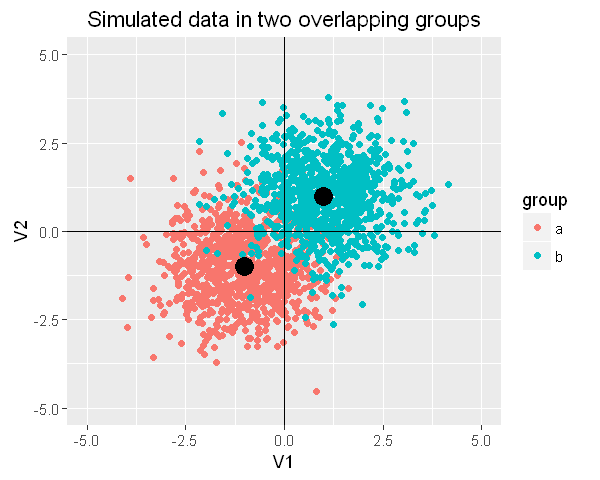

In [3]:
library("MASS")
library("ggplot2")

# show images inline
options(jupyter.plot_mimetypes = 'image/png')

# change size of plot
options(repr.plot.width = 5, repr.plot.height = 4)

# make sure the results can be replicated
set.seed(112)

# function to simulate data 
simulCluster <- function(nsamples, mean, dimension, group)
{
  Sigma <- diag(1, dimension, dimension)
  x <- mvrnorm(n = nsamples, rep(mean, dimension), Sigma)
  z <- as.data.frame(x)
  z$group = group
  z
}

# simulate data with 2 clusters
nsamples <- 1000
group_a <- simulCluster(nsamples, -1, 2, "a")
group_b <- simulCluster(nsamples, 1, 2, "b")
group_all <- rbind(group_a, group_b)

nclusters <- 2

# plot data 
ggplot(group_all, aes(x = V1, y = V2)) +
  geom_point(aes(colour = group)) +
  geom_point(data = data.frame(V1 = c(-1, 1), V2 = c(-1, 1)), size = 5) +
  xlim(-5, 5) + ylim(-5, 5) +
  geom_hline(yintercept = 0) +
  geom_vline(xintercept = 0) +
  ggtitle("Simulated data in two overlapping groups")

# assign data 
mydata = group_all[,1:2]

Then we can use kmeans() in R/MRO/MRS or rxKmeans() in MRS for the analysis.

In [4]:
# cluster analysis with kmeans(), it works on R, MRO, or MRS
fit_kmeans <- kmeans(mydata, nclusters, iter.max = 1000, algorithm = "Lloyd")

# cluster analysis with rxKmeans(), it works on MRS only
fit_rxKmeans <- rxKmeans( ~ V1 + V2, data = mydata,
                          numClusters = nclusters, algorithm = "lloyd")

The following code uses the XDF format data in rxKmeans() and compares the cluster assignment between kmeans() and rxKmeans(). The cluster assignments are the same between these two functions.


blocksPerRead must be 1 if predictions or residuals are be being written to the input data source.


              cluster_rxKmeans
cluster_kmeans    1    2
             1  991    0
             2    0 1009

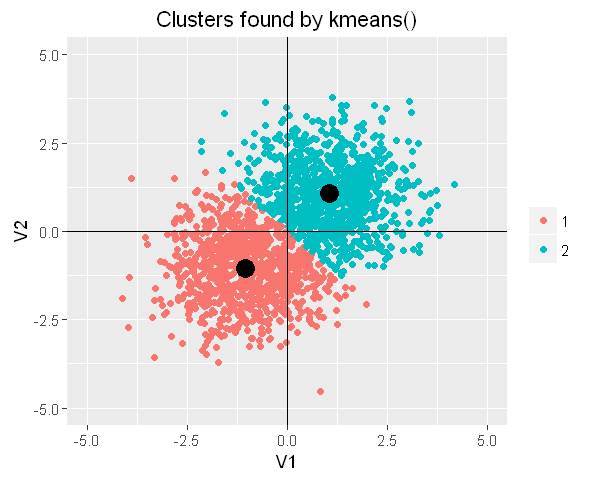

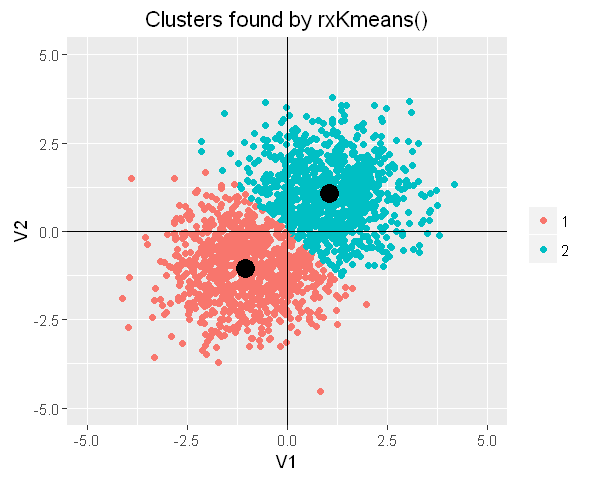

In [5]:
# save a dataset in XDF format
dataXDF = tempfile(fileext = ".xdf")
rxImport(inData = mydata, outFile = dataXDF, overwrite = TRUE)
# rxKmeans
fit_rxKmeans_2 <- rxKmeans(~ V1 + V2, data = dataXDF, 
                          numClusters = nclusters, algorithm = "lloyd",
                          outFile = dataXDF, outColName = "cluster", 
                          overwrite = TRUE)

# convert to dataframe and keep one variable only
cluster_rxKmeans <- rxDataStep(dataXDF, varsToKeep = "cluster")

# append cluster assignment from kmeans and rxKmeans
mydata_clusters <- cbind(
  group_all,
  cluster_kmeans = factor(fit_kmeans$cluster),
  cluster_rxKmeans = factor(cluster_rxKmeans$cluster))

# compare the cluster assignments between kmeans and rxKmeans
with(mydata_clusters, table(cluster_kmeans, cluster_rxKmeans))

# get cluster centroids 
cluster_centroid_kmeans <- fit_kmeans$centers
cluster_centroid_rxKmeans <- fit_rxKmeans_2$centers

# plot clusters from kmeans
ggplot(mydata_clusters, aes(x = V1, y = V2)) +
  geom_point(aes(colour = cluster_kmeans)) +
  geom_point(data = as.data.frame(cluster_centroid_kmeans), size = 5) +
  xlim(-5, 5) + ylim(-5, 5) +
  geom_hline(yintercept = 0) +
  geom_vline(xintercept = 0) +
  ggtitle("Clusters found by kmeans()") + 
  theme(legend.title=element_blank())

# plot clusters from rxKmeans
ggplot(mydata_clusters, aes(x = V1, y = V2)) +
  geom_point(aes(colour = cluster_rxKmeans)) +
  geom_point(data = as.data.frame(cluster_centroid_rxKmeans), size = 5) +
  xlim(-5, 5) + ylim(-5, 5) +
  geom_hline(yintercept = 0) +
  geom_vline(xintercept = 0) +
  ggtitle("Clusters found by rxKmeans()") +
  theme(legend.title=element_blank())

MRS has the HPA version of many other R functions. These MRS functions usually start with "rx" and are included in the RevoScaleR package. Figure 1 gives 3 three examples. More information on available HPA functions can be found [here][here link]

[![Figure 1][pic 1]][pic 1] Figure 1

[pic 1]: https://cloud.githubusercontent.com/assets/9322661/13321864/9bef4f40-db9f-11e5-83cf-08e49fc81d4e.PNG
[here link]: http://www.revolutionanalytics.com/revolution-r-enterprise-scaler

### 2.2 Packages
Data scientists who use R are familiar with the use of Packages. [Figure 2][pic 2] compares R, MRO and MRS by checking the packages installed by default. For example, MRO with MKL has two additional packages compared with base R: RevoUtilsMath and checkpoint. While some of the additional packages in MRS are available on CRAN, most of them (e.g., RevoScaleR) are not and can be found only after installing MRS. 

[![Figure 2][pic 2]][pic 2] Figure 2

[pic 2]: https://cloud.githubusercontent.com/assets/9322661/12992176/ddd25e30-d0e0-11e5-9f15-2c869c8caf3c.PNG

### 2.3 Platforms
[Figure 3][pic 3] from [a webinar's slides][slides link] compares R, MRO and MRS at the platform level. For example, the functions in the ScaleR module are included in the RevoScaleR package in [Figure 2][pic 2]. 

[![Figure 3][pic 3]][pic 3] Figure 3 

[pic 3]: https://cloud.githubusercontent.com/assets/9322661/12992513/e5fea8a0-d0e2-11e5-9893-06c929e7a1d0.PNG
[slides link]: https://info.microsoft.com/rs/157-GQE-382/images/EN-WBNR-Slidedeck-Using-Microsoft-R-Server-for-Scalability.pdf
[pic 2]: https://cloud.githubusercontent.com/assets/9322661/12992176/ddd25e30-d0e0-11e5-9f15-2c869c8caf3c.PNG

## 3 Performance Comparison

MRS solves two problems associated with using R: capacity (handling the size of datasets and models) and speed. [Figure 4][pic 4] compares R, MRO and MRS in these two areas. In terms of capacity, using HPA in MRS increases the size of data that can be analyzed. In the speed perspective, certain matrix related base-R functions can perform better in MRO and MRS than base-R due to  MKL. The HPA functions in MRS perform better than their base-R counterparts for large datasets. We'll look into these two areas in this section.

[![Figure 4][pic 4]][pic 4] Figure 4 

[pic 4]: https://cloud.githubusercontent.com/assets/9322661/13857242/6af81d5c-ec4f-11e5-9aa2-b100d22c0c13.PNG

### 3.1 Capacity
Both R and MRO can only process data in-memory. So if the data size is larger than memory size, they cannot load the data successfully and thus cannot process them. This also applies to base R functions under the MRS environment. Even when the data size is less than memory they could fail for more complicated analyses. 

The HPA functions in MRS, on the other hand, allows processing data block by block. To do this it uses a data file format (.xdf) that is extremely efficient for both reading and writing data. These functions can still process in-memory data. But they allow the data to be disk-based as well. 

For example, the following example shows that for a large dataset rxKmeans() runs successfully but kmeans() does not.

We start by simulating data with 60,000,000 rows and 2 columns, which takes up 2.2 GB disk space.

In [6]:
library("MASS")

# make sure the results can be replicated
set.seed(0)

# simulate data and append
nsamples <- 3*10^7 # use this to generate a large dataset
# nsamples <- 10^3 # for testing purpose
group_a <- simulCluster(nsamples, -1, 2, "a")
group_b <- simulCluster(nsamples, 1, 2, "b")
group_all <- rbind(group_a, group_b)

nclusters <- 2

# save data
mydata = group_all[, 1:2]
dataCSV = tempfile(fileext = ".csv")
dataXDF = tempfile(fileext = ".xdf")
write.csv(group_all, dataCSV, row.names = FALSE)
rxImport(inData = dataCSV, outFile = dataXDF, overwrite = TRUE)

When the following code uses kmeans() to analyze the data, an error message - “cannot allocate vector of size 915.5 Mb … Reached total allocation of 7167Mb: see help(memory.size)” - was returned. 

In [7]:
# cluster analysis with kmeans
system_time_R <- 
  system.time(
    {
      fit <- kmeans(mydata, nclusters,
                    iter.max = 1000,
                    algorithm = "Lloyd")
    })

Warning message:
In unlist(X, recursive = FALSE, use.names = FALSE): Reached total allocation of 7167Mb: see help(memory.size)Warning message:
In unlist(X, recursive = FALSE, use.names = FALSE): Reached total allocation of 7167Mb: see help(memory.size)Warning message:
In unlist(X, recursive = FALSE, use.names = FALSE): Reached total allocation of 7167Mb: see help(memory.size)Warning message:
In unlist(X, recursive = FALSE, use.names = FALSE): Reached total allocation of 7167Mb: see help(memory.size)

ERROR: Error: cannot allocate vector of size 915.5 Mb


Timing stopped at: 257.39 6.12 319.03 


The following code uses the rxKmeans() function and returned results after 4 minutes.

In [8]:
# cluster analysis with rxKmeans
system_time_MRS <- 
  system.time(
    {
      clust <- rxKmeans( ~ V1 + V2, data = dataXDF,
                         numClusters = nclusters,
                         algorithm = "lloyd",
                         outFile = dataXDF,
                         outColName = "cluster",
                         overwrite = TRUE)
    })


blocksPerRead must be 1 if predictions or residuals are be being written to the input data source.


### 3.2 Speed

#### 3.2.1 Base R Functions
With the RevoUtilsMath package on multi-core computers, MRO performs better than base R for many matrix related functions. For example, running the following code from [MRAN's Performance Benchmarks page][benchmark link] on R, MRO, and MRS shows that MRO and MRS performed better than R. 

[benchmark link]: https://mran.revolutionanalytics.com/documents/rro/multithread

In [9]:
if(require("RevoUtilsMath")){
  print(paste("The number of threads is:", getMKLthreads()))
  # setMKLthreads(4) # set 4 threads
  # setMKLthreads(1) # set 1 thread
}

# Initialization
set.seed (1)
m <- 10000
n <-  5000
A <- matrix (runif (m*n),m,n)

# Matrix multiply
system.time (B <- crossprod(A))

# Cholesky Factorization
system.time (C <- chol(B))

# Singular Value Decomposition
m <- 10000
n <- 2000
A <- matrix (runif (m*n),m,n)
system.time (S <- svd (A,nu=0,nv=0))

# Principal Components Analysis
m <- 10000
n <- 2000
A <- matrix (runif (m*n),m,n)
system.time (P <- prcomp(A))

# Linear Discriminant Analysis
library('MASS')
g <- 5
k <- round (m/2)
A <- data.frame (A, fac=sample (LETTERS[1:g],m,replace=TRUE))
train <- sample(1:m, k)
system.time (L <- lda(fac ~., data=A, prior=rep(1,g)/g, subset=train))

[1] "The number of threads is: 4"


   user  system elapsed 
 148.54  176.76  235.01 

   user  system elapsed 
   7.98    0.56    4.40 

   user  system elapsed 
  52.35    4.50   18.12 

   user  system elapsed 
 114.34   10.45   37.82 

   user  system elapsed 
 165.66   13.20   98.02 

[Figure 5][pic 5] summarizes the speed comparison on 4 platforms: 
* Base R 
* MRO without MKL
* MRO with MKL
* MRS

From Figure 5 we can make several observations: 
* There is little performance difference between R and MRO when MKL (the RevoUtilsMath package) is not installed. 
* MRO has significant better performance than R when MKL is installed. 
* The performance is similar between MRS and MRO when MKL is installed. 

So the installation of MKL helped speed up the calculations related to matrix. MKL can be used for MRO but not for base R.

[![Figure 5][pic 5]][pic 5] Figure 5

[pic 5]: https://cloud.githubusercontent.com/assets/9322661/12991031/59fc7e92-d0db-11e5-8618-935152f82d6a.PNG

When the calculation does not involve matrix, however, MKL will not help much for standard R functions. For example, the following code can be run on the same four platforms as shown above.

In [10]:
# simulate data 
nsamples <- 10 ^ 7 # this was used on different platforms
# nsamples <- 1000 # for testing purpose
group_a <- simulCluster(nsamples, -1, 2, "a")
group_b <- simulCluster(nsamples, 1, 2, "b")
group_all <- rbind(group_a, group_b)

nclusters <- 2

mydata = group_all[, 1:2]
# K-Means Cluster Analysis
system_time_r <- system.time(fit <- kmeans(mydata, nclusters,
                                           iter.max = 1000,
                                           algorithm = "Lloyd"))

Figure 6 compares the speed across the platforms for the kmeans() function. It can be seen that the speed of running kmeans() is similar between R, MRO, and MRS. 

[![Figure 6][pic 6]][pic 6] Figure 6

[pic 6]: https://cloud.githubusercontent.com/assets/9322661/12991942/a460485c-d0df-11e5-855a-5e2bc4db2103.PNG

#### 3.2.2 Base R vs HPA Functions
By changing the sample size of the simulated data we can compare the speed of using kmeans() and rxKmeans() for different data sizes. The code in the following block compares the performance. The results show that the HPA function rxKmeans() runs faster than kmeans() when the size of datasets gets large and that their performance is similar for smaller datasets. 

In [11]:
# to save timing results
myresult <- data.frame(nsamples = integer(), time_r = double(),
                       time_rre = double())

# list of sample sizes
nsamples_list <- c(5 * 10 ^ 2, 10 ^ 3, 5 * 10 ^ 3, 10 ^ 4, 5 * 10 ^ 4, 10 ^ 5,
                   5 * 10 ^ 5, 10 ^ 6, 5 * 10 ^ 6, 10 ^ 7)

for (nsamples in nsamples_list)
{
  # simulate data and append
  group_a <- simulCluster(nsamples, -1, 2, "a")
  group_b <- simulCluster(nsamples, 1, 2, "b")
  group_all <- rbind(group_a, group_b)
  mydata = group_all[, 1:2]

  nclusters <- 2

  # kmeans with R
  system_time_r <- system.time(fit <- kmeans(mydata, nclusters,
                                               iter.max = 1000,
                                               algorithm = "Lloyd"))

  # kmeans with MRS
  system_time_rre <- system.time(clust <- rxKmeans( ~ V1 + V2, data = mydata,
                                                     numClusters = nclusters,
                                                     algorithm = "lloyd"))

  # combine
  newrow <- data.frame(nsamples = nsamples,
                         time_r = as.numeric(system_time_r[3]),
                         time_rre = as.numeric(system_time_rre[3]))
  myresult <- rbind(myresult, newrow)

}

myresult$nsamples <- 2 * myresult$nsamples
mydata <- myresult
mydata$nsamples_log <- log10(mydata$nsamples)
mydata


,nsamples,time_r,time_rre,nsamples_log
1,1000,0.01,0.02,3
2,2000,0,0.02,3.30103
3,10000,0,0.03,4
4,20000,0.01,0.07,4.30103
5,1e+05,0.07,0.06,5
6,2e+05,0.26,0.1,5.30103
7,1e+06,1.58,0.56,6
8,2e+06,2.11,1.13,6.30103
9,1e+07,15.14,6.07,7
10,2e+07,26.08,15.39,7.30103


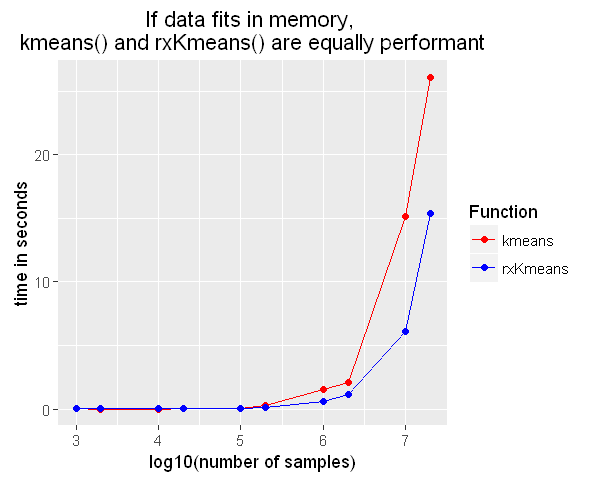

In [12]:
# generate plot
ggplot(data = mydata, aes(x = nsamples_log)) +
    geom_point(aes(y = time_r, colour = "kmeans")) +
    geom_line(aes(y = time_r, colour = "kmeans")) +
    geom_point(aes(y = time_rre, colour = "rxKmeans")) +
    geom_line(aes(y = time_rre, colour = "rxKmeans")) +
    scale_x_continuous(breaks = seq(2, 8, by = 1)) +
    scale_colour_manual("Function", values = c(kmeans = "red", rxKmeans = "blue")) +
    xlab("log10(number of samples)") +
    ylab("time in seconds") +
    ggtitle("If data fits in memory, \nkmeans() and rxKmeans() are equally performant")

## 4 Conclusion
[Figure 7][pic 7] summarize scenarios where R, MRO, and MRS can be used depending on the amount of data and the availability of MRS's HPA functions. Whenever R can be used, MRO can be used with the additional benefit of multi-thread computation for certain matrix related computations. MRS can be used whenever R or MRO can be used and it allows the possibility of using HPA functions that provide better performance in terms of both speed and capacity. 

[![Figure 7][pic 7]][pic 7] Figure 7

[pic 7]: https://cloud.githubusercontent.com/assets/9322661/13078756/d5fb2708-d48e-11e5-83ec-ed18c75bf5f8.PNG



## 5 Additional Resources
This write-up should have helped you understand how MRS and MRO relate to R. Below are some additional resources you can refer to. 

* [Microsoft Announcing MRO and MRS][blog link]
* [ZDNet Reporting on MRO and MRS] [ZDNet]
* [DataCamp - Big Data Analysis with Revolution R Enterprise][datacamp link]
* [MRS Documentation][mrs doc]
* [Revolution R Enterprise: Faster Than SAS][mrs vs sas]

[blog link]: http://blogs.technet.com/b/machinelearning/archive/2016/01/12/making-r-the-enterprise-standard-for-cross-platform-analytics-both-on-premises-and-in-the-cloud.aspx
[ZDNet]: http://www.zdnet.com/article/microsoft-delivers-free-version-of-its-r-analytics-server-for-developers/
[datacamp link]: https://www.datacamp.com/courses/big-data-revolution-r-enterprise-tutorial
[mrs doc]: http://packages.revolutionanalytics.com/doc/8.0.0/win/
[mrs vs sas]: http://www.revolutionanalytics.com/sites/default/files/revolution-analytics-sas-benchmark-whitepaper-mar2014.pdf

---  
Created by a Microsoft Employee.  
Copyright (C) Microsoft. All Rights Reserved.